In [1]:
Packages <- c("dplyr","broom","geosphere","swfscMisc", "geosphere","MASS", "fields","lattice", "ggplot2", "bbmle", "ncdf4","dplyr","tidyr", "stringr", "tidyverse", "raster", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")


In [3]:
#read in data and add site names
conn_mat_all <- brick("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD_integer.nc", values=T) 
#read in the data for the number of grid cells per site (site ids are North- South, as in, Palanas is number 1)
sites_n <- read.table("~/oceanography/ROMS/input//camotes_vertices_sites_results_water_only.txt", sep=" ", header=T, stringsAsFactors = F)
#the order of sites in the connectivity matrix
sites_order <- read.table("~/oceanography/ROMS/input/sites_order_as_in_roms.txt", sep=" ", header=T, stringsAsFactors = F)

sites <- as.character(c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop", "Hicgop South", "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Pangasugan", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon", "SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "CAI", "Other"))
site_ind <- c(seq(1,28, 1))
site_id <- as.data.frame(cbind(sites, site_ind), stringsAsFactors = F)
site_id$site_ind <- as.numeric(site_id$site_ind)


[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named sink BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named source BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named time BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"


In [2]:
#add in dates (seasons here are field seasons, not monsoon seasons)
col <- "date"
col2 <- "index"

season1 <- as.data.frame(seq(as.Date("2010/10/01"), as.Date("2011/05/31"), by="days"))
names(season1) <- col

season2 <- as.data.frame(seq(as.Date("2011/10/01"), as.Date("2012/05/31"), by="days"))
names(season2) <- col

season3 <- as.data.frame(seq(as.Date("2012/10/01"), as.Date("2013/05/31"), by="days"))
names(season3) <- col

season4 <- as.data.frame(seq(as.Date("2013/10/01"), as.Date("2014/04/18"), by="days"))
names(season4) <- col

all_dates <- bind_rows(season1, season2, season3, season4)
time_step <- as.data.frame(seq(1,930,1))
names(time_step)<- col2
all_dates2 <- bind_cols(time_step, all_dates)
dim(all_dates2)


[1] 930   2

In [ ]:
#make each daily connectivity matrix into a df and then pull them all together into a list
#conn_mat_list <- vector("list", nrow(all_dates2))

#date_df <- do.call("rbind", replicate(784, date, simplify = FALSE))

conn_mat_full <- as.data.frame(matrix(nrow=0, ncol=4))

cols_conn_mat <- c("date","sink", "source", "number")
cols_tmp <- c("sink", "source", "number")

names(conn_mat_full) <- cols_conn_mat

for(i in 1:nrow(all_dates2)){
    
    index_eval <- all_dates2$index[i]
    
    tmp <- as.data.frame(conn_mat_all[[i]], xy=T)   #pull out a data frame for each date
    names(tmp) <- cols_tmp
    
    date <- filter(all_dates2, index==index_eval)[2] #grab the date
    date_df <- do.call("rbind", replicate(784, date, simplify = FALSE)) #make a df of the date
    tmp2 <- bind_cols(date_df, tmp)

 
    conn_mat_full <- rbind(conn_mat_full, tmp2) 
}



In [ ]:
#connect site names
conn_mat_full2 <- left_join(conn_mat_full, site_id, by=c(source="site_ind")) %>%
    dplyr::select(-source) %>%
    rename(source="sites")
    
conn_mat_full3 <- left_join(conn_mat_full2, site_id, by=c(sink="site_ind")) %>%
    dplyr::select(-sink) %>%
    rename(destination="sites")

    

In [ ]:
#make all versions of Hicgop "Hicgop South" to match empirical data
conn_mat_full3 <- conn_mat_full3 %>%
    mutate(source=ifelse(source=="Hicgop", "Hicgop South", source)) %>%
    mutate(destination=ifelse(destination=="Hicgop", "Hicgop South", destination))

#mark which sources/destinations were sampled in real life
UnsampledSites <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan", "Other") #although we didn't sample the Camotes Islands, I'm going to leave it in the simulation results for now to use it in the GLM of ROMS model. It will be remove in filtering to produce the df that will be used for comparisons to genetic observations
#mark the monsoon seasons in which they dispersed, based on the same criteria I used for the parentage indirectly through the growth estimates
NEM <- c(11, 12, 1, 2, 3, 4, 5, 6)
SWM <- c(7, 8, 9, 10)

#add a column showing which sources and destinations were empirically sampled, and corresponding date/year/season data
conn_mat_full4 <- conn_mat_full3 %>%
    mutate(SourceSampled= ifelse(source %!in% UnsampledSites, "yes", "no")) %>%
    mutate(DestSampled= ifelse(destination %!in% UnsampledSites, "yes", "no")) %>%
    mutate(SimMonth=month(ymd(date))) %>%
    mutate(SimDay=month(ymd(date))) %>%
    mutate(SimYear=year(ymd(date))) %>%
    mutate(YearSampled=ifelse(date %in% season1$date, "2011", ifelse(date %in% season2$date, "2012", ifelse(date %in% season3$date, "2013", "2014")))) %>%
    mutate(YearSampled=as.factor(YearSampled)) %>%
    mutate(SimMonsoon=ifelse(SimMonth %in% NEM, "NEM", "SWM")) %>%
    rename(DailyParticles="number") %>%
    relocate(DailyParticles,.after=SimMonsoon)
    
#note to self, I think I messed up sources/destinations in the orginal for loop!!!! so I'm grouping by source below, but that's because the true destination column is misnamed "source" in the code and I haven't figured it out yet
#!!!!
 

__Skip above and read the tidied data frame below__

In [2]:
#head(conn_mat_full4)
#write.csv(conn_mat_full4, file="~/oceanography/script_output/SimConnectivityTable.csv", row.names=F)
SimConnDF <- read.csv(file="~/oceanography/script_output/SimConnectivityTable.csv", header=T) %>%
    mutate(YearSampled=as.character(YearSampled))
UnsampledSites <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan", "Other") #although we didn't sample the Camotes Islands, I'm going to leave it in the simulation results for now to use it in the GLM of ROMS model. It will be remove in filtering to produce the df that will be used for comparisons to genetic observations

#add in the numbers of particles seeded at each site
SeededParticles <- read.csv("~/oceanography/ROMS/data/Particles_Per_Release_Site_Renamed.csv", header=F)
col <- c("site", "ParticlesReleasedDaily")
colnames(SeededParticles) <- col
SimConnDF <- left_join(SimConnDF, SeededParticles, by=c(source="site")) %>% 
    filter(source != c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6"))#sand flat sites shouldn't be releasing particles, they should only be destinations. Remove rows where they are sources

In [4]:
head(SimConnDF)

date,source,destination,SourceSampled,DestSampled,SimMonth,SimDay,SimYear,YearSampled,SimMonsoon,DailyParticles,ParticlesReleasedDaily
2010-10-01,Other,Palanas,no,yes,10,10,2010,2011,SWM,9,4497728
2010-10-01,Other,Wangag,no,yes,10,10,2010,2011,SWM,4,4497728
2010-10-01,Other,Magbangon,no,yes,10,10,2010,2011,SWM,11,4497728
2010-10-01,Other,Cabatoan,no,yes,10,10,2010,2011,SWM,12,4497728
2010-10-01,Other,Caridad Cemetery,no,yes,10,10,2010,2011,SWM,0,4497728
2010-10-01,Other,Caridad Proper,no,yes,10,10,2010,2011,SWM,1,4497728


In [27]:
#don't really know if I want to do what's in this cell...
##add together all of the particles for each season. At some point need to consider matching times that we sampled, from the fish meta-data?
##replace XN with years
#SimConnDF <- SimConnDF %>%
#    group_by(destination, YearSampled) %>%
#    mutate(AnnTotalRec=sum(DailyParticles)) %>% #Annual here means the year that would be considered one year in the genetic analysis
#    mutate(AnnTotalRecFromSampSites=ifelse(DestSampled=="yes" & SourceSampled=="yes",sum(DailyParticles), 0)) #this comes up at NA otherwise...maybe that's important for the GLM though. Expect the unsampled sites won't be used for the GLM. think more about this.
#
#

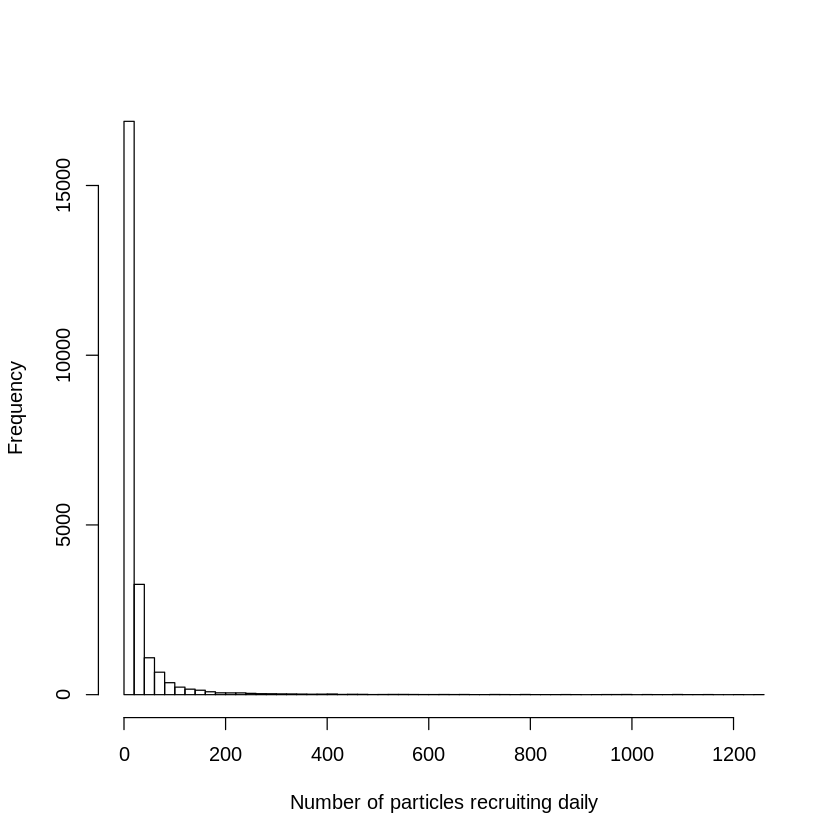

In [5]:
#check that everything looks correct
test <- SimConnDF %>% filter(DailyParticles >1 & 
                             SourceSampled=="yes" & DestSampled=="yes")
#pdf("~/oceanography/script_output/HistNumParticlesRecruiting.pdf")
hist(test$DailyParticles, breaks=50, xlab="Number of particles recruiting daily", main=NULL)
#dev.off()


In [7]:
##put in North-South order for kernel fitting, also used for GLM connectivity data frame?
SitesNS <- read.csv("~/parentage/text_file/sites_NS.txt", stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S. Magbangon" , "Magbangon", site)) %>%
    filter(site != "N. Magbangon") 

###add site size - is this worth adding? It would be a random effect, I already know that it affects the number of particles...
##Reef_sizes <- read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.", header=FALSE)

#add the distances between sites, calculated from the site centroids
centroidsSamp <- read.csv("~/parentage/kernel_fitting/1340_loci/input/site_centroids.csv", header=TRUE, stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S.Magbangon" , "Magbangon", site)) %>%
    filter(site != "N.Magbangon") %>%
    filter(site %in% SitesNS$site)

#I want to average the Camotes Islands values and add those in. That way I can use that distance in the GLM of the simulated ROMS as response variable. this can be subsetted out for the observed data by using the "source/dests sampled" columns
#pull out the camotes centroids for a df with just them, to average lat/lon points with (centroids)
CAI <- c("camotes_central1", "camotes_central2", "camotes_east1", "camotes_east2", "camotes_west1", "camotes_west2")

centroidsSim <- read.csv("~/parentage/kernel_fitting/1340_loci/input/site_centroids.csv", header=TRUE, stringsAsFactors =F)
CamotesAvg <- centroidsSim %>%
    filter(site %in% CAI) %>%
    mutate(lon=mean(lon)) %>% #take the average lon
    mutate(lat=mean(lat)) %>% #take the average lat
    slice_head()

CamotesAvg$site <- "CAI"#make a one row DF for this value that can be added to centroids so it's distances are calculated

#add to tidy distance
centroids <- bind_rows(centroidsSamp, CamotesAvg) 

##calculate the distance from all potential parents and all potential offspring
all_possible_dists <- as.data.frame(rdist.earth(as.matrix(centroids[,c('lon', 'lat')]), as.matrix(centroids[,c('lon', 'lat')]), miles=FALSE, R=6371))

##attach the sample_ids to each distance, so you can also get site and year
colnames(all_possible_dists) <- centroids$site
all_possible_dists$site_i <- centroids$site

##gather into tidy df
all_possible_dists_tidy <- all_possible_dists %>%
    dplyr::select(site_i, everything()) %>%
    gather(2:20, key=site_j, value=dist_km) 
nrow(all_possible_dists_tidy)

SimConnDFDist <- left_join(SimConnDF, all_possible_dists_tidy, by=c(source="site_i", destination="site_j")) %>%
        group_by(source) %>% #think about how I might want to group on temporal scales too
        mutate(NormSourceAllYears=DailyParticles/sum(DailyParticles)) %>% #group by source only to plot this
        ungroup() %>%
        group_by(source, SimYear) %>%
        mutate(NormSourceAnnual=DailyParticles/sum(ParticlesReleasedDaily)) %>%
        ungroup() %>%
        group_by(source, SimMonsoon) %>%
        mutate(NormSourceMonsoon=DailyParticles/sum(ParticlesReleasedDaily))
    

[1] 361

In [8]:
head(SimConnDFDist)

date,source,destination,SourceSampled,DestSampled,SimMonth,SimDay,SimYear,YearSampled,SimMonsoon,DailyParticles,ParticlesReleasedDaily,dist_km,NormSourceAllYears,NormSourceAnnual,NormSourceMonsoon
2010-10-01,Other,Palanas,no,yes,10,10,2010,2011,SWM,9,4497728,NA,2.151624e-09,7.767897e-10,5.763278e-10
2010-10-01,Other,Wangag,no,yes,10,10,2010,2011,SWM,4,4497728,NA,9.562773e-10,3.452399e-10,2.561457e-10
2010-10-01,Other,Magbangon,no,yes,10,10,2010,2011,SWM,11,4497728,NA,2.629763e-09,9.494096e-10,7.044007e-10
2010-10-01,Other,Cabatoan,no,yes,10,10,2010,2011,SWM,12,4497728,NA,2.868832e-09,1.035720e-09,7.684371e-10
2010-10-01,Other,Caridad Cemetery,no,yes,10,10,2010,2011,SWM,0,4497728,NA,0.000000e+00,0.000000e+00,0.000000e+00
2010-10-01,Other,Caridad Proper,no,yes,10,10,2010,2011,SWM,1,4497728,NA,2.390693e-10,8.630997e-11,6.403643e-11


In [14]:
#add a continuous value for direction in the form of a bearing
#col <- c("site_i", "site_j", "bearing")
AllBearings <- matrix(nrow=0, ncol=3)
#colnames(AllBearings) <- col

for(i in 1:nrow(centroids)) {
    
    site_i <- centroids[i,] #take the site name
    site_i_coords <- as.matrix(site_i[,2:3]) #get the lon/lat

    #now compare this site to all other sites for bearing
    
    bearings <- matrix(nrow=nrow(centroids), ncol=3)

    for(j in 1:nrow(centroids)){
        


        site_j <- centroids[j,]
        site_j_coords <- as.matrix(site_j[,2:3]) #get the lon/lat

        bearing <- geosphere::bearing(site_i_coords, site_j_coords)
        bearings[j,1] <- site_i[1,1] #add to data frame
        bearings[j,2] <- site_j[1,1]
        bearings[j,3] <- bearing

    }
    AllBearings <- rbind(AllBearings, bearings)

}
nrow(AllBearings)#should be 361
nrow(centroids)
19*19

col <- c("site_i", "site_j", "direction")
AllBearings <- as.data.frame(AllBearings)
colnames(AllBearings) <- col
#write.csv(AllBearings, file="~/oceanography/script_output/SurveyData/AllBearings.csv", row.names=F)

SimConnDFDir <- left_join(SimConnDFDist, AllBearings, by=c(source="site_i", destination="site_j")) %>%
    mutate(direction=as.numeric(direction))

[1] 361

[1] 19

[1] 361

In [10]:
#write.csv(SimConnDFDir, file="~/oceanography/script_output/SimConnectivityTableWithMeta.csv", row.names=F)


__At this point SimConnDFDir has all the available information about just the simulated data__

In [31]:

#add how well we sampled sites- proportion of habitat sampled
load("~/parentage/r_data/cumulative_prop_hab_sampled_by_site.RData")
PropSamp <- cumulative_prop_hab_sampled_by_site %>%
    mutate(total_possible_sample_anems = ifelse(site=="Caridad Proper", 4, total_possible_sample_anems) ) %>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="Caridad Proper" & total_anems_sampled==4, 1, total_prop_hab_sampled_anems_tidied) ) %>%
    mutate(total_possible_sample_anems = ifelse(site=="Sitio Lonas", total_anems_sampled, total_possible_sample_anems) ) %>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="Sitio Lonas", 1, total_prop_hab_sampled_anems_tidied) )%>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(is.nan(total_prop_hab_sampled_anems_tidied), 0, total_prop_hab_sampled_anems_tidied) ) %>%
    dplyr::select(site, time_frame, end_year, total_prop_hab_sampled_anems_tidied) 

PropSamp$site <- gsub(". ", ".", PropSamp$site, fixed=TRUE) #fix spaces in Magbangon names

S.Mag <- PropSamp %>%#make a table for all of the S. Mabangon years/prop sampled. Then join to the DF, make a column adding S.Magbangon values to all rows of prop sampled, but only sub that value in for PropSamp in N.Magbangon rows, then rename N.Magbangon as Magbangon
    filter(site=="S.Magbangon") %>%
    dplyr::select(site, end_year, total_prop_hab_sampled_anems_tidied) %>%
    rename(S.MagVal="total_prop_hab_sampled_anems_tidied", extra="site")

PropSamp <- left_join(PropSamp, S.Mag, by=c("end_year")) %>%
    mutate(S.MagSum=total_prop_hab_sampled_anems_tidied+S.MagVal) %>% #create col adding the S.Mag values to prop hab - keep in mind values could be greater than 1- if so change them to 1
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="N.Magbangon", S.MagSum, total_prop_hab_sampled_anems_tidied)) %>%#sub this value in for only N.Mag
    mutate(site=ifelse(site=="N.Magbangon", "Magbangon", site)) %>%#change N.Mag name to generic Mag
    filter(site !="S.Magbangon") %>%#eliminate the S.Mag rows, they are now repeats
    dplyr::select(-S.MagVal,-extra, -S.MagSum, -time_frame) %>%
    rename(PropSamp="total_prop_hab_sampled_anems_tidied")


#check if there are values>1, should be none
sum(which(PropSamp$total_prop_hab_sampled_anems_tidied >1)) #zero, that's good

#first, summarize the simulated data to the level of a sampling year, remember, this data frame DOES NOT include unsampled sites at the moment
SimConnDFInt <- SimConnDFDir %>%
    ungroup() %>%
    group_by(source, destination, YearSampled) %>%
    mutate(AnnRecPart=sum(DailyParticles)) %>% # this is a really confusing column name, so drop the similar ones from earlier that are for the purposes of figuring out the unassigned juveniles for kernel fitting
    ungroup() %>%
    dplyr::select(-AnnTotalRec, -AnnTotalRecFromSampSites) #yikes figure out how to rename these confusing as is...
#last piece to explore ROMS model GLM- the Camotes don't fit into the North/South paradigm I have going, so manually say the direction is 
SimConnDFProp <- left_join(SimConnDFInt, PropSamp, by=c(source="site", YearSampled="end_year")) %>%#use end year here, remembering that it's cumulative prop hab sampled that is relevant to the parentage analysis
    rename(SourcePropSamp="PropSamp")
SimConnDFMeta <- left_join(SimConnDFProp, PropSamp, by=c(destination="site", YearSampled="end_year")) %>% #use end year here, remembering that it's cumulative prop hab sampled that is relevant to the parentage analysis
    rename(DestPropSamp="PropSamp") %>%
    ungroup() %>% #ungroup by year, otherwise grouping will override year filtering
    filter(YearSampled %in% c("2012", "2013", "2014")) %>% #remove 2011 simulation results, we didn't sampled that year    
    filter(source %!in% UnsampledSites & source !="CAI") %>% #we narrow down to only sampled sites at this point, because this is the data frame that will be joined to the observed data
    filter(destination%!in% UnsampledSites & destination!= "CAI") 


[1] 0

__add in genetic data__

__CELL BELOW IS WORKING FOR GLM OF OBSERVED DATA BY SIMULATED DATA__

In [22]:
##add in the empirical dispersal data from the genetics
ObsDisp <- read.csv(file="~/parentage/colony2/20200605_1340loci/results/20200624colony_dispersaldirection.csv", header=T, stringsAsFactors=F)
#
ObsDisp$offs_site <- gsub(". ", ".", ObsDisp$offs_site, fixed=TRUE) #fix spaces in Magbangon names
ObsDisp$par_site <- gsub(". ", ".", ObsDisp$par_site, fixed=TRUE) #fix spaces in Magbangon names

##just like in PropSamp, combine Magbangons to match simulation
###for the observed parentage, there's only one case of a disp obs to/from the same site in the same year from both N and S Mag. So that's the only obs to combine, do it manually
ObsDisp <- ObsDisp %>%
    filter(year %in% c("2012", "2013", "2014")) %>% #, "2014"  #only use the data from the years that overlap between simulations and empirical sampling
    dplyr::select(year, dist_par_km, offs_site, par_site) %>%
    group_by(offs_site, par_site, year) %>%
    summarise(obs_disp=n()) %>%
    mutate(obs_disp=ifelse(offs_site=="N.Magbangon" & par_site=="Palanas" & year=="2013", 2, obs_disp)) %>% #manually change the 1 to 2 to combine N/S Mag
    filter(par_site !="S.Magbangon" & offs_site !="Palanas") %>% #drop the S.Mag obs so we don't double count
    mutate(offs_site=ifelse(offs_site=="N.Magbangon", "Magbangon", offs_site)) %>%#change N.Mag name to generic Mag
    mutate(par_site=ifelse(par_site=="N.Magbangon", "Magbangon", par_site)) %>%#change N.Mag name to generic Mag  
    mutate(offs_site=ifelse(offs_site=="S.Magbangon", "Magbangon", offs_site)) %>%#change S.Mag name to generic Mag
    mutate(par_site=ifelse(par_site=="S.Magbangon", "Magbangon", par_site)) %>% #change S.Mag name to generic Mag    
    mutate(year=as.character(year)) %>%
    ungroup() 

#first, summarize the simulated data to the level of a sampling year and remove duplicates (daily rows, now that it's already summarized)
SimConnDFMetaAnn <- SimConnDFMeta %>%
    ungroup() %>%
    distinct(YearSampled, source, destination, .keep_all = T) %>%
    dplyr::select(-date)
GenSimConn <- left_join(SimConnDFMetaAnn, ObsDisp, by=c(source="par_site", destination="offs_site", YearSampled="year"))%>%
    mutate(obs_disp=ifelse(is.na(obs_disp), 0, obs_disp)) %>%
    mutate(direction=as.numeric(direction)) 
sum(GenSimConn$obs_disp) #should be 24
#add a column for binomial 1/0 if dispersal occured along that route

#write out the table with all of the genetic sampling and simulated data
#write.csv(GenSimConn, file="~/oceanography/script_output/GenSimConnectivityFullTable.csv", row.names=F)


`summarise()` regrouping output by 'offs_site', 'par_site' (override with `.groups` argument)


[1] 24

__Can skip above and read in the data frame made from the above code__

In [14]:
#GenSimConn <- read.csv(file="~/oceanography/script_output/GenSimConnectivityFullTable.csv", header=T)


__Make some plots__

In [ ]:
#what are the routes that create these peaks in direction annually?

#are there similar patterns seasonally?

#plot the connectivity matrix with of the roms model

In [35]:
SimConnDFDir2 <- SimConnDFDir %>% #summarise to plot the distribution of directions and distances in time periods
    filter(!is.na(direction)) %>%     #exclude the "other" sites, for which distance and direction are unknown
    group_by(direction) %>%
    mutate(DirTotalParticlesAll=sum(DailyParticles)) %>% #total in each direction class in all years combined
    ungroup() %>%
    group_by(SimYear, direction) %>%
    mutate(DirTotalParticlesAnnual=sum(DailyParticles)) %>% #total in each direction class in each year separately
    ungroup() %>%
    group_by(SimMonsoon, direction) %>%
    mutate(DirTotalParticlesSeasonal=sum(DailyParticles)) %>% #total in each direction class in each monsoon season separately
    ungroup() %>% 
    group_by(dist_km) %>%
    mutate(DistTotalParticlesAll=sum(DailyParticles)) %>% #total in each distance class in all years combined
    ungroup() %>%
    group_by(SimYear, dist_km) %>%
    mutate(DistTotalParticlesAnnual=sum(DailyParticles)) %>% #total in each distance class in each year separately
    ungroup() %>%
    group_by(SimMonsoon, dist_km) %>%
    mutate(DistTotalParticlesSeasonal=sum(DailyParticles)) %>% #total in each distance class in each monsoon season separately
    ungroup()
    
    

In [31]:
str(SimConnDFDir2)


tibble [703,080 × 23] (S3: tbl_df/tbl/data.frame)
 $ date                      : Factor w/ 930 levels "2010-10-01","2010-10-02",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ source                    : chr [1:703080] "Other" "Other" "Other" "Other" ...
 $ destination               : chr [1:703080] "Palanas" "Wangag" "Magbangon" "Cabatoan" ...
 $ SourceSampled             : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ DestSampled               : Factor w/ 2 levels "no","yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ SimMonth                  : int [1:703080] 10 10 10 10 10 10 10 10 10 10 ...
 $ SimDay                    : int [1:703080] 10 10 10 10 10 10 10 10 10 10 ...
 $ SimYear                   : int [1:703080] 2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 ...
 $ YearSampled               : chr [1:703080] "2011" "2011" "2011" "2011" ...
 $ SimMonsoon                : Factor w/ 2 levels "NEM","SWM": 2 2 2 2 2 2 2 2 2 2 ...
 $ DailyParticles            : int [1:703080] 9 4 11 12 0 1 0 0 22 11 ...

__plot distances in each year (simulated and sampled) and season__

In [56]:
#plot, can filter for only one year too- %>% filter(DistTotalParticlesAll < 5e7)
AnnualDistanceScatterSimYear <- ggplot(data=SimConnDFDir2 , aes(x=dist_km, y=DistTotalParticlesAnnual, color=as.character(SimYear), fill=as.character(SimYear)), alpha=0.5) +
    geom_point(size=0.2)+
    scale_y_log10() +
    geom_smooth() +
    xlab("Distance (km)") +
    ylab("Log10 Total particles recruiting") 
#ggsave(filename="AnnualDistanceScatterSimYear.pdf", plot=AnnualDistanceScatterSimYear, path="~/oceanography/figures")


Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 40122 rows containing non-finite values (stat_smooth).”

In [59]:
#plot, can filter for only one year too- %>% filter(DistTotalParticlesAll < 5e7)
AnnualDistanceScatterSampYear <- ggplot(data=SimConnDFDir2 , aes(x=dist_km, y=DistTotalParticlesAnnual, color=as.character(YearSampled), fill=as.character(YearSampled)), alpha=0.5) +
    geom_point(size=0.2)+
    scale_y_log10() +
    geom_smooth() +
    xlab("Distance (km)") +
    ylab("Log10 Total particles recruiting") 
#ggsave(filename="AnnualDistanceScatterSampYear.pdf", plot=AnnualDistanceScatterSampYear, path="~/oceanography/figures")


Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 40122 rows containing non-finite values (stat_smooth).”

In [61]:
#plot, can filter for only one year too- %>% filter(DistTotalParticlesAll < 5e7)
DistanceScatterSimMonsoon <- ggplot(data=SimConnDFDir2 , aes(x=dist_km, y=DistTotalParticlesSeasonal, color=as.character(SimMonsoon), fill=as.character(SimMonsoon)), alpha=0.5) +
    geom_point(size=0.2)+
    scale_y_log10() +
    geom_smooth() +
    xlab("Distance (km)") +
    ylab("Log10 Total particles recruiting") 
#ggsave(filename="DistanceScatterSimMonsoon.pdf", plot=DistanceScatterSimMonsoon, path="~/oceanography/figures")
#DistanceScatterSimMonsoon

Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 8556 rows containing non-finite values (stat_smooth).”

__plot directions in each year (simulated and sampled) and season__

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 38936 rows containing non-finite values (stat_smooth).”Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 38936 rows containing non-finite values (stat_smooth).”

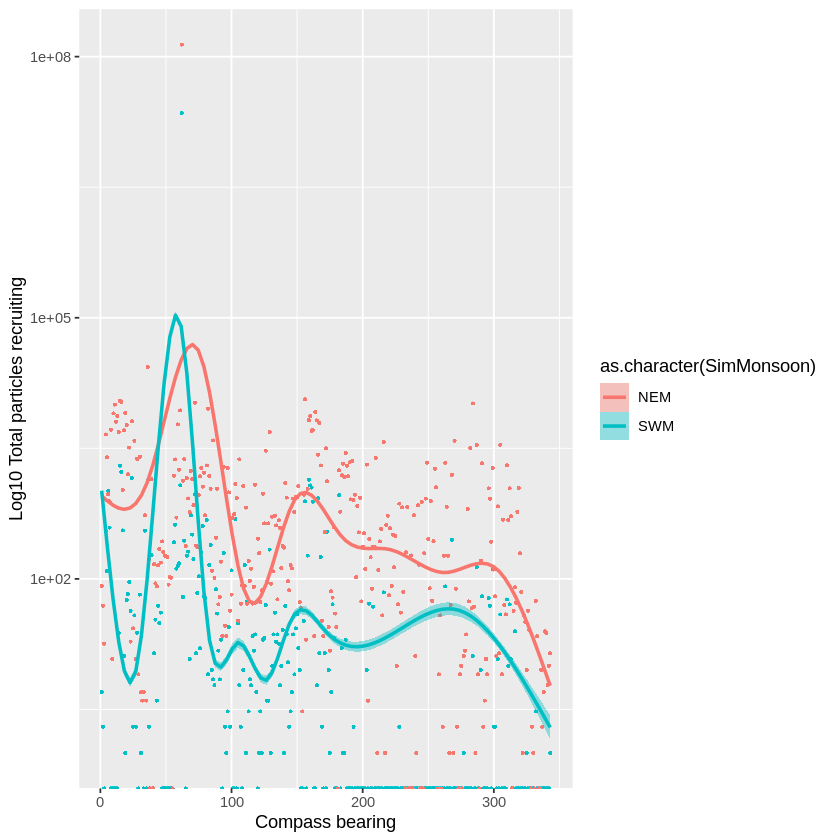

In [75]:
DirScatterSimMonsoon <- ggplot(data=SimConnDFDir2 , aes(x=direction, y=DirTotalParticlesSeasonal, color=as.character(SimMonsoon), fill=as.character(SimMonsoon)), alpha=0.5) +
    geom_point(size=0.2)+
    scale_y_log10() +
    geom_smooth() +
    xlab("Compass bearing") +
    ylab("Log10 Total particles recruiting") 
DirScatterSimMonsoon

ggsave(filename="DirScatterSimMonsoon.pdf", plot=DirScatterSimMonsoon, path="~/oceanography/figures")


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 90947 rows containing non-finite values (stat_smooth).”Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 90947 rows containing non-finite values (stat_smooth).”

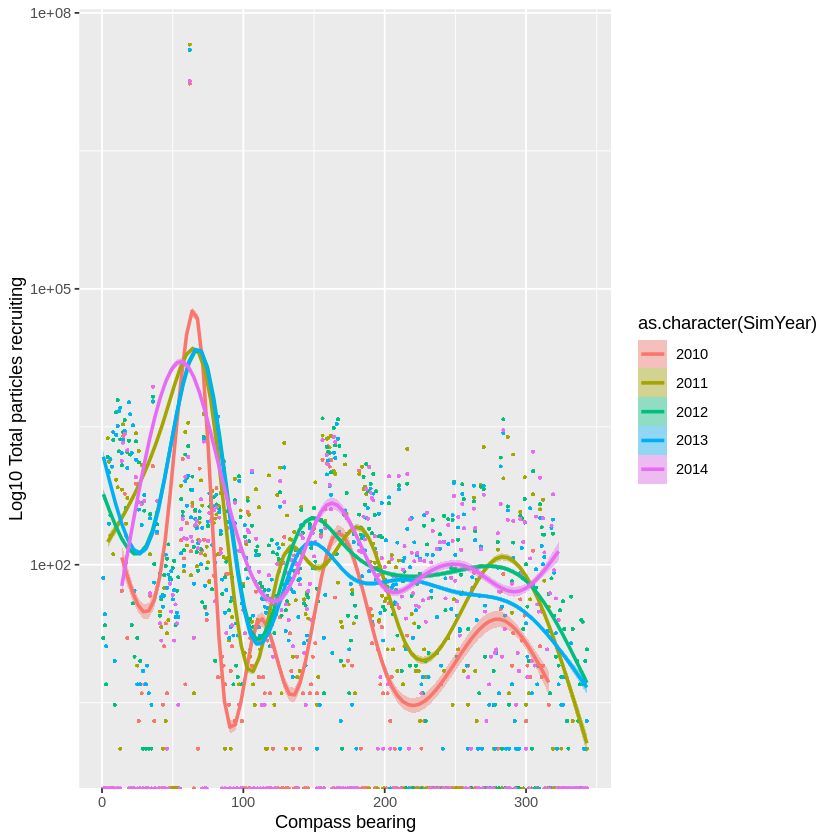

In [76]:

DirScatterSimYear <- ggplot(data=SimConnDFDir2 , aes(x=direction, y=DirTotalParticlesAnnual, color=as.character(SimYear), fill=as.character(SimYear)), alpha=0.5) +
    geom_point(size=0.2)+
    scale_y_log10() +
    geom_smooth() +
    xlab("Compass bearing") +
    ylab("Log10 Total particles recruiting") 
DirScatterSimYear
ggsave(filename="DirScatterSimYear.pdf", plot=DirScatterSimYear, path="~/oceanography/figures")


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 90947 rows containing non-finite values (stat_smooth).”Saving 6.67 x 6.67 in image
Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 90947 rows containing non-finite values (stat_smooth).”

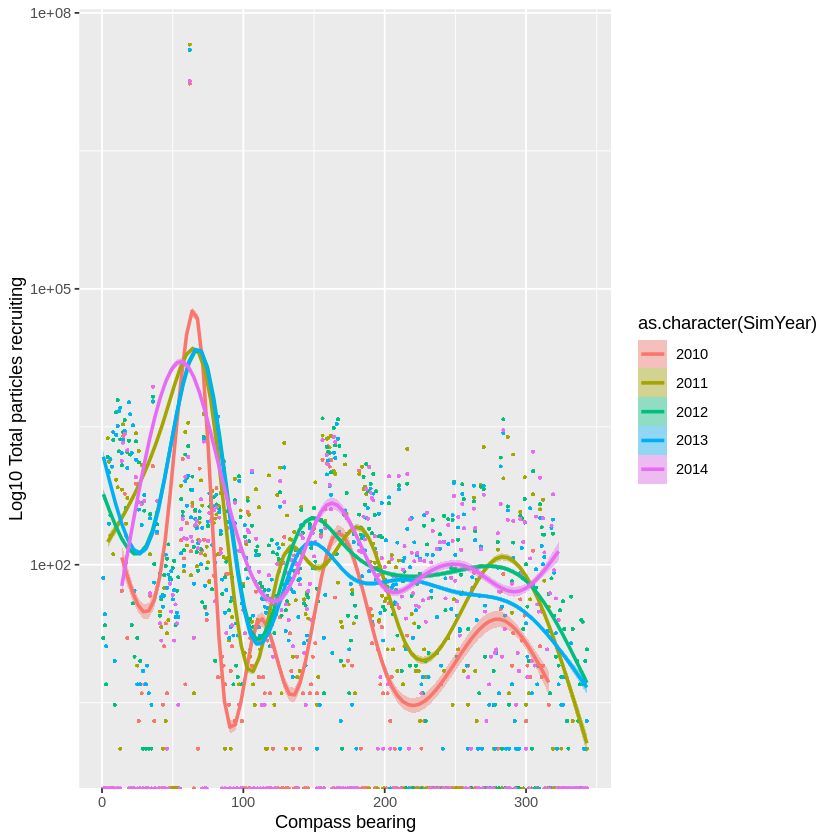

In [79]:

DirScatterSampYear <- ggplot(data=SimConnDFDir2 , aes(x=direction, y=DirTotalParticlesAnnual, color=as.character(YearSampled), fill=as.character(YearSampled)), alpha=0.5) +
    geom_point(size=0.2)+
    scale_y_log10() +
    geom_smooth() +
    xlab("Compass bearing") +
    ylab("Log10 Total particles recruiting") 
DirScatterSimYear
ggsave(filename="DirScatterSampYear.pdf", plot=DirScatterSampYear, path="~/oceanography/figures")


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 90947 rows containing non-finite values (stat_smooth).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 90947 rows containing non-finite values (stat_smooth).”

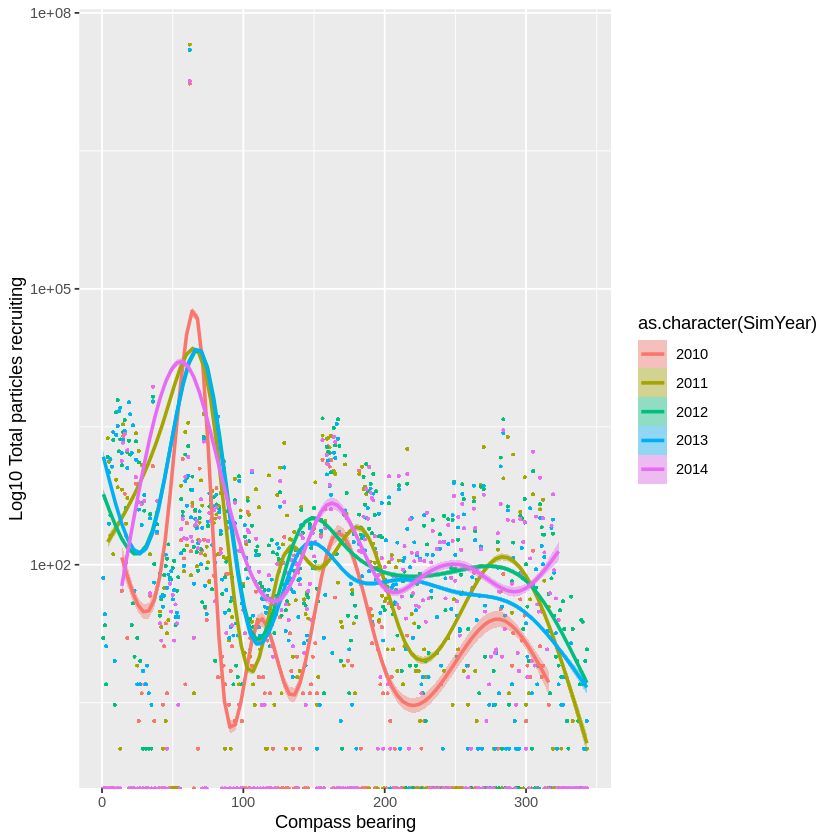

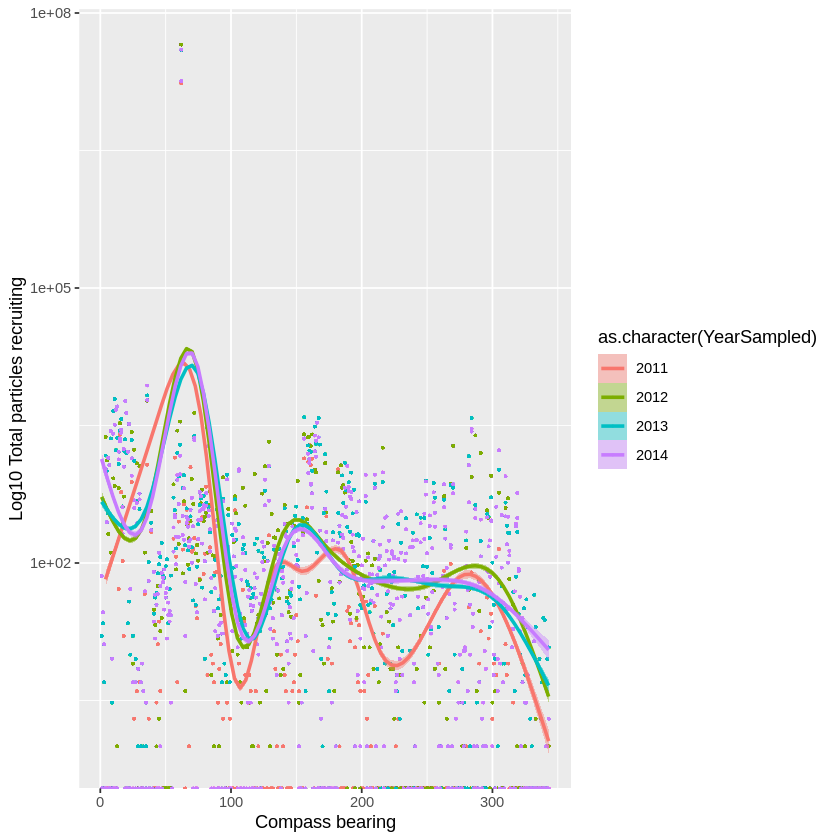

In [80]:
DirScatterSimYear
DirScatterSampYear


In [81]:
#connectivity matrixes
head(SimConnDFDir)

date,source,destination,SourceSampled,DestSampled,SimMonth,SimDay,SimYear,YearSampled,SimMonsoon,DailyParticles,ParticlesReleasedDaily,dist_km,NormSourceAllYears,NormSourceAnnual,NormSourceMonsoon,direction
2010-10-01,Other,Palanas,no,yes,10,10,2010,2011,SWM,9,4497728,NA,2.151624e-09,7.767897e-10,5.763278e-10,NA
2010-10-01,Other,Wangag,no,yes,10,10,2010,2011,SWM,4,4497728,NA,9.562773e-10,3.452399e-10,2.561457e-10,NA
2010-10-01,Other,Magbangon,no,yes,10,10,2010,2011,SWM,11,4497728,NA,2.629763e-09,9.494096e-10,7.044007e-10,NA
2010-10-01,Other,Cabatoan,no,yes,10,10,2010,2011,SWM,12,4497728,NA,2.868832e-09,1.035720e-09,7.684371e-10,NA
2010-10-01,Other,Caridad Cemetery,no,yes,10,10,2010,2011,SWM,0,4497728,NA,0.000000e+00,0.000000e+00,0.000000e+00,NA
2010-10-01,Other,Caridad Proper,no,yes,10,10,2010,2011,SWM,1,4497728,NA,2.390693e-10,8.630997e-11,6.403643e-11,NA


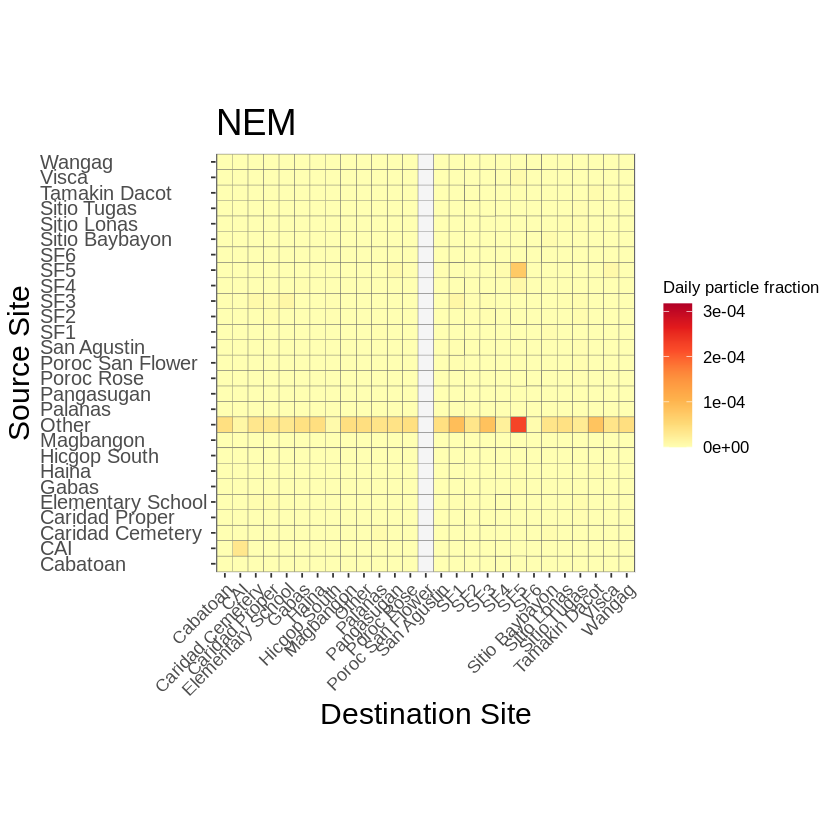

In [86]:
ggplot(SimConnDFDir%>% filter(SimMonsoon=="NEM"), aes(source, destination)) +
geom_tile(aes(fill = NormSourceMonsoon), color = "grey40") +
   geom_tile(aes(fill = NormSourceMonsoon), color = "grey40") +
   scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("NEM") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())


In [ ]:
cv_df <- cv_df %>%
    mutate(org_site= ifelse(org_site=="Tamakin Dacot", "Tomakin Dako", org_site)) %>%
    mutate(dest_site= ifelse(dest_site=="Tamakin Dacot", "Tomakin Dako", dest_site))
#
#big-small
cv_df$org_site <-factor(cv_df$org_site, levels=sites)
cv_df$dest_site <-factor(cv_df$dest_site, levels=sites)


#name <- expression(r ^2)
#sd <- sd_df4_dist$dist_mid_to_mid_km
#plot
cv_plot <- ggplot(cv_df, aes(org_site, dest_site)) +
    geom_tile(aes(fill=cv)) + 
    coord_fixed() +
    scale_fill_viridis(option="viridis", name="CV")+#name="Standard\ndeviation\n") + 
    ylab("Destination Site") +
    xlab("Origin Site") +
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1)) +
    theme(plot.title = element_text(hjust = 1))+
    theme(legend.text=element_text(size=10))+
    theme(legend.title=element_text(size=10))+ 
    theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())

   # scale_x_continuous(breaks=c(0, 10, 20, 27))    #scale_colour_continuous(guide = "colorbar", guides(fill = guide_legend("title")))
    
cv_plot